<a href="https://colab.research.google.com/github/izmailovpavel/neurips_bdl_starter_kit/blob/main/evaluation_phase_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Inference in Bayesian Deep Learning *Evaluation Phase*: Getting Started in JAX

In this colab we will walk you through downloading the data, running your method and generating a submission for the evaluation phase of our NeurIPS 2021 competition. In this colab we use the JAX framework.

See also our [getting started guide](https://colab.sandbox.google.com/github/izmailovpavel/neurips_bdl_starter_kit/blob/main/getting_started_jax.ipynb) for the development phase, for developing and testing your methods against our HMC samples.

Useful references:
- [Competition website](https://izmailovpavel.github.io/neurips_bdl_competition/)
- [Efficient implementation of several baselines in JAX](https://github.com/google-research/google-research/tree/master/bnn_hmc)
- [Submission platform]  TODO


## Setting up colab

Colab provides an easy-to-use environment for working on the competition with access to free computational resources. However, you should also be able to run this notebook locally after installing the required dependencies. If you use colab, please select a `GPU` runtime type.

## Preparing the data

In [2]:
# uncomment order to re-install the starter kit
# !rm -rf neurips_bdl_starter_kit

!git clone https://github.com/izmailovpavel/neurips_bdl_starter_kit
! pip install git+https://github.com/deepmind/dm-haiku
! pip install optax

import sys
import math
import jax
import tensorflow as tf
import optax
import matplotlib
import numpy as onp
from jax import numpy as jnp
from matplotlib import pyplot as plt
import tqdm

sys.path.append("neurips_bdl_starter_kit")
import jax_models as models

Cloning into 'neurips_bdl_starter_kit'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 130 (delta 65), reused 77 (delta 31), pack-reused 0
Receiving objects: 100% (130/130), 4.84 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (65/65), done.
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-io00727g
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-io00727g
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-py3-none-any.whl size=533610 sha256=8dcf288560a5acc51bca0def50c7812908bfb015dff9e8a6ffc9bc5fa0c176dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-zexfyq_y/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
     |████████████████████████████████| 118 kB 5.3 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 


We provide the datasets used in this competition in a public Google Cloud Storage bucket in the `.npz` format. You can also download the data to your computer using these links:

- [CIFAR-10](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz)
- [MedMNIST](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz)
- [UCI-Gap](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/energy_anon.npz)
- [Diabetic Retinopathy](https://storage.googleapis.com/neurips2021_bdl_competition/evaluation_phase/retinopathy_anon.npz)

In colab, you can download the data using `gsutil`. In this colab we will use the [*Diabetic Retinopathy*](https://github.com/google/uncertainty-baselines/tree/main/baselines/diabetic_retinopathy_detection) dataset as our main example.

**Note:** for each of the datasets, we provide the data after applying the same preprocessing that was used in our HMC runs.

**Note:** we do not include the true test set labels `y_test` for the evaluation datasets. You are not allowed to use the true labels on the test data in your submissions.

In [22]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/retinopathy_anon.npz .
data = onp.load("retinopathy_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

Copying gs://neurips2021_bdl_competition/evaluation_phase/retinopathy_anon.npz...
- [1/1 files][  3.6 GiB/  3.6 GiB] 100% Done  30.2 MiB/s ETA 00:00:00           
Operation completed over 1 objects/3.6 GiB.                                      


In this dataset, the goal is to detect diabetic retinopathy using images of blood vessels in the eye.

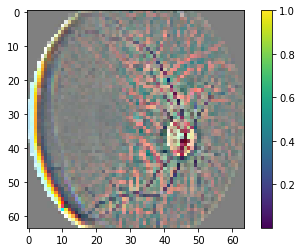

In [6]:
plt.imshow(x_train[1])
plt.colorbar()

We define a tf.data.Dataset for the train and test datasets.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

## Model and Losses

We provide the code for all the models used in the competition in the `neurips_bdl_starter_kit/jax_models.py` module. Here, we will load a CNN model that we used on the diabetic retinopathy detection problem. The models are implemented in [`haiku`](https://github.com/deepmind/dm-haiku).

We also define the cross-entropy likelihood (`log_likelihood_fn`) and Gaussian prior (`log_prior_fn`), and the corresponding posterior log-density (`log_posterior_fn`). The `log_posterior_wgrad_fn` computes the posterior log-density and its gradients with respect to the parameters of the model.

The `evaluate_fn` function computes the accuracy and predictions of the model on a given dataset; we will use this function to generate the predictions for our submission.

**Warning:** The diabetic retinopathy dataset shows significant class imbalance. When training with SGD, it struggles to fit the data, as we will see below.

In [42]:
net_apply, net_init = models.get_model("retinopathy_cnn", data_info={"num_classes": 2})

prior_variance = 0.05

def log_likelihood_fn(params, batch, is_training=True):
    """Computes the log-likelihood."""
    x, y = batch
    logits = net_apply(params, None, x, is_training)
    num_classes = logits.shape[-1]
    labels = jax.nn.one_hot(y, num_classes)
    softmax_xent = jnp.sum(labels * jax.nn.log_softmax(logits))

    return softmax_xent


def log_prior_fn(params):
    """Computes the Gaussian prior log-density."""
    n_params = sum([p.size for p in jax.tree_leaves(params)])
    exp_term = sum(jax.tree_leaves(jax.tree_map(
        lambda p: (-p**2 / (2 * prior_variance)).sum(), params)))
    norm_constant = -0.5 * n_params * jnp.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant


def log_posterior_fn(params, batch, is_training=True):
    log_lik = log_likelihood_fn(params, batch, is_training=True)
    log_prior = log_prior_fn(params)
    return log_lik + log_prior
    # return log_lik


@jax.jit
def get_accuracy_fn(batch, params):
    x, y = batch
    logits = net_apply(params, None, x, False)
    probs = jax.nn.softmax(logits, axis=1)
    preds = jnp.argmax(logits, axis=1)
    accuracy = (preds == y).mean()
    return accuracy, probs


def evaluate_fn(dataset, params):
    sum_accuracy = 0
    all_probs = []
    for x, y in dataset:
        x, y = jnp.asarray(x), jnp.asarray(y)
        batch_accuracy, batch_probs = get_accuracy_fn((x, y), params)
        sum_accuracy += batch_accuracy.item()
        all_probs.append(onp.asarray(batch_probs))
    all_probs = jnp.concatenate(all_probs, axis=0)
    return sum_accuracy / len(dataset), all_probs


log_posterior_wgrad_fn = jax.jit(jax.value_and_grad(log_posterior_fn, argnums=0))

In [49]:
seed = jax.random.PRNGKey(0)
key, net_init_key = jax.random.split(seed, 2)
init_data, _ = next(iter(train_dataset))
init_data = jnp.asarray(init_data)[None, :]
params = net_init(net_init_key, init_data, True)

## Optimizer

In this colab we will train an approximate maximum-a-posteriori (MAP) solution as our submission for simplicity. You can find efficient implementations of more advanced baselines [here](https://github.com/google-research/google-research/tree/master/bnn_hmc).

We will use SGD with momentum. You can adjust the hyper-parameters or switch to a different optimizer by changing the code below.

`update_fn` implements a single optimization step on a mini-batch of data.

In [50]:
batch_size = 100
test_batch_size = 1000
num_epochs = 1
shuffle_buffer_size = 1000
momentum_decay = 0.9
init_lr = 1.e-4

train_dataset_batched = train_dataset.shuffle(shuffle_buffer_size, reshuffle_each_iteration=True)
train_dataset_batched = train_dataset_batched.batch(batch_size)
test_dataset_batched = test_dataset.batch(test_batch_size)

epoch_steps = len(train_dataset_batched)
total_steps = epoch_steps * num_epochs



def lr_schedule(step):
    t = step / total_steps
    return 0.5 * init_lr * (1 + jnp.cos(t * onp.pi))

optimizer = optax.chain(
    optax.trace(decay=momentum_decay, nesterov=False),
    optax.scale_by_schedule(lr_schedule))
opt_state = optimizer.init(params)


@jax.jit
def update_fn(batch, params, opt_state):
  x, y = batch
  loss, grad = log_posterior_wgrad_fn(params, (x, y))
  updates, new_opt_state = optimizer.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state, loss

## Training

We will run training for 1 epoch, which can take several minutes to complete. Note that in order to achieve good results you need to run the method substantially longer and tune the hyper-parameters.

In [51]:
for epoch in range(num_epochs):
    sum_loss = 0.
    for i, (x, y) in tqdm.tqdm(enumerate(train_dataset_batched)):
        x, y = jnp.asarray(x), jnp.asarray(y)
        params, opt_state, loss = update_fn((x, y), params, opt_state)
        sum_loss += loss
        if i % 50 == 0:
          print(f"\tPosterior Log-density: {loss}")

    
    test_acc, all_test_probs = evaluate_fn(test_dataset_batched, params)
    print("Epoch {}".format(epoch))
    print("\tAverage loss: {}".format(sum_loss / epoch_steps))
    print("\tTest accuracy: {}".format(test_acc))

all_test_probs = onp.asarray(all_test_probs)

1it [00:06,  6.61s/it]

	Posterior Log-density: 37468.2578125


51it [01:18,  1.40s/it]

	Posterior Log-density: 39395.83984375


101it [02:29,  1.47s/it]

	Posterior Log-density: 39697.96484375


151it [03:43,  1.46s/it]

	Posterior Log-density: 39727.97265625


201it [04:55,  1.43s/it]

	Posterior Log-density: 39735.50390625


251it [06:07,  1.50s/it]

	Posterior Log-density: 39737.55859375


301it [07:19,  1.40s/it]

	Posterior Log-density: 39730.77734375


351it [08:31,  1.44s/it]

	Posterior Log-density: 39731.83984375


352it [08:35,  1.47s/it]


Epoch 0
	Average loss: 39541.0234375
	Test accuracy: 0.8071975403053816


Due to class imbalance, with default parameters the model learns to always predict class `0`. Be sure to check that your methods produce more meaningful predictions:

In [54]:
(jnp.argmax(all_test_probs, axis=1) == 0).mean()

DeviceArray(1., dtype=float32)

## Preparing the submission
Once you run the code above, `all_test_probs` should contain an array of size TODO x 2 where the rows correspond to test datapoints and columns correspond to classes.

Now, we need to save the array as `retinopathy_probs.csv` and create a zip archive with this file.

In [55]:
onp.savetxt("retinopathy_probs.csv", all_test_probs)

!zip submission.zip retinopathy_probs.csv

  adding: retinopathy_probs.csv (deflated 98%)


Finally, you can download the submission by running the code below. If the download doesn't start, check that your browser did not block it automatically.

In [56]:
from google.colab import files
files.download('submission.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now you can head over to the [submission system] TODO and upload your submission. Good luck :)

## Extended track

If you want to participate in the extended track, you will need to produce predictions on 3 additional datasets: CIFAR-10 (with AlexNet-like architecture), [UCI-Gap](https://arxiv.org/abs/1906.11537) (Energy) and [MedMNIST](https://medmnist.com/) (dermamnist). 

Here, we will walk you through the datasets, architectures and priors and show you how to prepare the full submission.

### Classification datasets

For CIFAR-10 and MedMNIST the process of loading the data and model and preparing the predictions is fully analogous to Diabetic Retinopathy (see above for a detailed walk-through). So, we will simply show how to download the data and get the corresponding models.

**Note**: note that the prior variance differs between datasets. We list the correct value for each dataset.

#### CIFAR-10

In [3]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz .
data = onp.load("cifar_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

Copying gs://neurips2021_bdl_competition/evaluation_phase/cifar_anon.npz...
\ [1/1 files][  1.1 GiB/  1.1 GiB] 100% Done  47.2 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.1 GiB.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


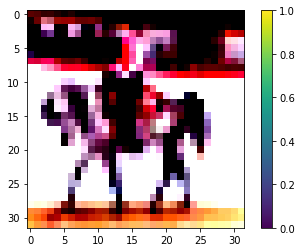

In [4]:
plt.imshow(x_train[0])
plt.colorbar()

In [5]:
net_apply, net_init = models.get_model("cifar_alexnet", data_info={"num_classes": 10})
prior_variance = 0.05

In [7]:
n_test = len(y_test)
cifar_fake_preds = onp.asarray(jax.nn.softmax(onp.random.randn(n_test, 10)))
onp.savetxt("cifar_probs.csv", cifar_fake_preds)

#### MedMNIST

In [8]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz .
data = onp.load("dermamnist_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

Copying gs://neurips2021_bdl_competition/evaluation_phase/dermamnist_anon.npz...
- [1/1 files][ 20.2 MiB/ 20.2 MiB] 100% Done                                    
Operation completed over 1 objects/20.2 MiB.                                     


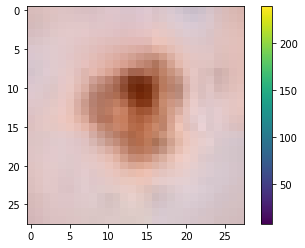

In [9]:
plt.imshow(x_train[4])
plt.colorbar()

In [10]:
net_apply, net_init = models.get_model("medmnist_lenet", data_info={"num_classes": 7})
prior_variance = 0.01

In [11]:
n_test = len(y_test)
medmnist_fake_preds = onp.asarray(jax.nn.softmax(onp.random.randn(n_test, 7)))
onp.savetxt("medmnist_probs.csv", medmnist_fake_preds)

### UCI Regression

For the regression data, we use a slightly different output format. We will walk you through defining the model and generating predictions here.

In [12]:
!gsutil -m cp -r gs://neurips2021_bdl_competition/evaluation_phase/energy_anon.npz .
data = onp.load("energy_anon.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

Copying gs://neurips2021_bdl_competition/evaluation_phase/energy_anon.npz...
/ [1/1 files][ 54.0 KiB/ 54.0 KiB] 100% Done                                    
Operation completed over 1 objects/54.0 KiB.                                     


In [13]:
net_apply, net_init = models.get_model("uci_mlp", {})
prior_variance = 1 / 30

Our model will output a Gaussian distribution for each of the input points. Specifically, the model produces two scalar outputs: $\mu$ and $\sigma_{isp}$, the mean and the inverse [softplus](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softplus.html) of the standard deviation. Let us define the likelihood for this model.

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


def log_likelihood_fn(params, batch, is_training=True):
    """Computes the negative log-likelihood.

    The outputs of the network should be two-dimensional.
    The first output is treated as predictive mean. The second output is treated
    as inverse-softplus of the predictive standard deviation.
    """
    x, y = batch
    predictions = net_apply(params, None, x, is_training)

    predictions_mean, predictions_std = jnp.split(predictions, [1], axis=-1)
    predictions_std = jax.nn.softplus(predictions_std)

    se = (predictions_mean - y)**2
    log_likelihood = (-0.5 * se / predictions_std**2 -
                      0.5 * jnp.log(predictions_std**2 * 2 * math.pi))
    log_likelihood = jnp.sum(log_likelihood)

    return log_likelihood

def log_prior_fn(params):
    """Computes the Gaussian prior log-density."""
    n_params = sum([p.size for p in jax.tree_leaves(params)])
    exp_term = sum(jax.tree_leaves(jax.tree_map(
        lambda p: (-p**2 / (2 * prior_variance)).sum(), params)))
    norm_constant = -0.5 * n_params * jnp.log((2 * math.pi * prior_variance))
    return exp_term + norm_constant

def log_posterior_fn(params, batch, is_training=True):
    log_lik = log_likelihood_fn(params, batch, is_training=True)
    log_prior = log_prior_fn(params)
    return log_lik + log_prior


log_posterior_wgrad_fn = jax.jit(jax.value_and_grad(log_posterior_fn, argnums=0))

Now let's initialize the model and train it similarly to the Diabetic Retinopathy example.

In [15]:
seed = jax.random.PRNGKey(0)
key, net_init_key = jax.random.split(seed, 2)
init_data, _ = next(iter(train_dataset))
init_data = jnp.asarray(init_data)[None, :]
params = net_init(net_init_key, init_data, True)

In [16]:
num_epochs = 1000
momentum_decay = 0.9
init_lr = 1.e-6


total_steps = num_epochs


def lr_schedule(step):
    t = step / total_steps
    return 0.5 * init_lr * (1 + jnp.cos(t * onp.pi))

optimizer = optax.chain(
    optax.trace(decay=momentum_decay, nesterov=False),
    optax.scale_by_schedule(lr_schedule))
opt_state = optimizer.init(params)


@jax.jit
def update_fn(batch, params, opt_state):
  x, y = batch
  loss, grad = log_posterior_wgrad_fn(params, (x, y))
  updates, new_opt_state = optimizer.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state, loss

In [17]:
for epoch in range(num_epochs):
    x, y = jnp.asarray(x_train), jnp.asarray(y_train)
    params, opt_state, loss = update_fn((x, y), params, opt_state)
    if epoch % 50 == 0:
      print(f"\tPosterior Log-density: {loss}")

	Posterior Log-density: -1548.1424560546875
	Posterior Log-density: -504.2290344238281
	Posterior Log-density: -162.7780303955078
	Posterior Log-density: -28.746253967285156
	Posterior Log-density: 57.80284118652344
	Posterior Log-density: 125.72540283203125
	Posterior Log-density: 187.26531982421875
	Posterior Log-density: 238.76345825195312
	Posterior Log-density: 274.26690673828125
	Posterior Log-density: 301.8326110839844
	Posterior Log-density: 323.390869140625
	Posterior Log-density: 340.4429016113281
	Posterior Log-density: 353.7496032714844
	Posterior Log-density: 364.08447265625
	Posterior Log-density: 371.9789733886719
	Posterior Log-density: 377.64044189453125
	Posterior Log-density: 381.43304443359375
	Posterior Log-density: 383.750244140625
	Posterior Log-density: 384.9660949707031
	Posterior Log-density: 385.4149475097656


We can now compute and visualize the predictions on the train set. As we can see, the model was able to fit the train data.

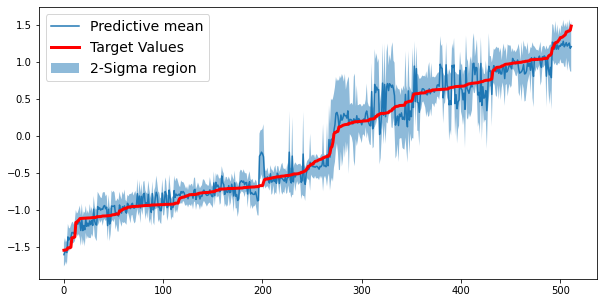

In [18]:
train_preds = net_apply(params, None, x_train, False)

plt.figure(figsize=(10, 5))
idx = onp.argsort(y_train[:, 0])

mu = train_preds[:, 0][idx]
sigma = train_preds[:, 1][idx]
sigma = jax.nn.softplus(sigma)

plt.plot(mu, label="Predictive mean")
plt.fill_between(onp.arange(len(mu)), mu + 2 * sigma, mu - 2 * sigma, alpha=0.5,
                 label="2-Sigma region")
plt.plot(y_train[:, 0][idx], "-r", lw=3, label="Target Values")
plt.legend(fontsize=14)

Now, let us produce the predictions on the test data that we will use in our submission. For UCI-Gap, we ask you to submit a CSV file with 256 rows and 1000 columns. Each row corresponds to a test datapoint $x_i$, and each colum corresponds to a sample from the predictive distribution $p(y \vert x_i)$. In our case, the predictive distribution is Gaussian, so we can produce the samples as follows:

In [19]:
num_samples = 1000
num_data = len(y_test)

test_preds = net_apply(params, None, x_test, False)
mu = test_preds[:, 0]
sigma = test_preds[:, 1]
sigma = jax.nn.softplus(sigma)

eps = onp.random.rand(num_data, num_samples)
samples = mu[:, None] + eps * sigma[:, None]
samples.shape

(256, 1000)

Let us save the samples to a CSV file.

In [20]:
onp.savetxt("uci_samples.csv", samples)

Now we can finally prepare the submission file!

In [25]:
!zip extended_submission.zip retinopathy_probs.csv cifar_probs.csv medmnist_probs.csv uci_samples.csv 

from google.colab import files
files.download('extended_submission.zip') 

updating: cifar_probs.csv (deflated 57%)
updating: medmnist_probs.csv (deflated 57%)
updating: uci_samples.csv (deflated 63%)
  adding: retinopathy_probs.csv (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>